In [196]:

from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from surprise import Reader, Dataset, SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, \
    KNNWithZScore, BaselineOnly, CoClustering, accuracy
from surprise.model_selection import cross_validate, train_test_split
init_notebook_mode(connected=True)

import numpy as np
import pandas as pd
import csv

import sklearn
from sklearn.decomposition import TruncatedSVD as truncated_svd

columns = ['id','id2','task','TaskId','rating']
frame = pd.read_csv('DataRecommenderSystem/DataInterviewVisitor.csv',sep=',', names=columns)
frame.head()

,id,id2,task,TaskId,rating
0,0,1,11010,1,7
1,1,1,10010,2,7
2,2,1,11010,3,8
3,3,1,1000,4,7
4,4,1,10000,5,6


In [197]:
columns2 =['TaskId','TaskName','Task']
tasks = pd.read_csv('DataRecommenderSystem/TasksInterviewVisitor.csv', sep=',', names = columns2, encoding='latin-1')
task_names = tasks[['TaskId','TaskName','Task']]
task_names.head()

#add
data = frame['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / frame.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} task-ratings'.format(frame.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)


#add

In [198]:
combined_task_data = pd.merge(frame, task_names, on='TaskId')
combined_task_data.head()

,id,id2,task,TaskId,rating,TaskName,Task
0,0,1,11010,1,7,Task1,11010
1,6,1,11010,1,9,Task1,11010
2,7,1,11010,1,7,Task1,11010
3,19,1,11010,1,10,Task1,11010
4,22,1,11010,1,4,Task1,11010


In [199]:
combined_task_data.groupby('TaskId')['rating'].count().sort_values(ascending=True).head()

filter_interview = combined_task_data['TaskId']==0
combined_task_data[filter_interview]['TaskName'].unique()

#add
# Create trace
trace = go.Histogram(x = combined_task_data.TaskId,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 200,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Task',
                   xaxis = dict(title = 'Number of Ratings Per Book'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.1)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)
#add

#add
# Create trace
trace = go.Histogram(x = combined_task_data.id,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 200,
                                  size = 10))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.1)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)
#add

In [200]:
rating_crosstab = combined_task_data.pivot_table(values='rating', index='id', columns=['TaskName','Task'], fill_value=0.01)
rating_crosstab

TaskName,Task1,Task10,Task2,Task3,Task4,Task5,Task6,Task7,Task8,Task9
Task,11010,1010,10010,1000,10000,1111110,11110,1110,111010,101110
id,,,,,,,,,,
0,7.00,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
1,0.01,0.01,7.00,0.01,0.01,0.01,0.01,0.01,0.01,0.01
2,0.01,0.01,0.01,8.00,0.01,0.01,0.01,0.01,0.01,0.01
3,0.01,0.01,0.01,0.01,7.00,0.01,0.01,0.01,0.01,0.01
4,0.01,0.01,0.01,0.01,0.01,6.00,0.01,0.01,0.01,0.01
...,...,...,...,...,...,...,...,...,...,...
96,0.01,0.01,0.01,0.01,0.01,0.01,0.01,9.00,0.01,0.01
97,0.01,0.01,0.01,0.01,0.01,0.01,0.01,9.00,0.01,0.01


In [201]:
rating_crosstab.shape
X = rating_crosstab.T
X.shape

(10, 99)

In [202]:
truncated_SVD = truncated_svd(n_components=11, random_state=0)

resultant_matrix = truncated_SVD.fit_transform(X)

resultant_matrix.shape

(10, 10)

In [203]:
corr_mat = np.corrcoef(resultant_matrix)
corr_mat.shape
task_names = rating_crosstab.columns
task_list = list(task_names)
task_list
task = task_list.index(('Task4',10000))
task
corr_1 = corr_mat[task]
corr_1.shape
corr_1

array([-0.10687176, -0.11442059, -0.10716372, -0.1112096 ,  1.        ,
       -0.1081206 , -0.1477027 , -0.11027737, -0.11590371, -0.07036676])

In [204]:
with open('DataRecommenderSystem/recommenderSystemInterview.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(corr_1)
    writer.writerow(list(task_names[(corr_1<=1) & (corr_1 > -0.12)]))



In [205]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(combined_task_data[['id', 'TaskId', 'rating']], reader)

In [206]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')   

print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


{'test_rmse': array([2.2858645 , 1.95943617, 1.79056882]),
 'fit_time': (0.0010006427764892578,
  0.0009989738464355469,
  0.0009996891021728516),
 'test_time': (0.0, 0.0, 0.0)}

In [207]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)



Estimating biases using als...
RMSE: 1.7696


1.7696384960808442

In [208]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]
print(best_predictions)
print(worst_predictions)

    uid  iid  rui       est                    details  Iu  Ui       err
21   11    2  7.0  7.169586  {'was_impossible': False}   0  14  0.169586
7     5    2  7.0  7.169586  {'was_impossible': False}   0  14  0.169586
13   65    1  7.0  7.276068  {'was_impossible': False}   0  21  0.276068
19   79    1  7.0  7.276068  {'was_impossible': False}   0  21  0.276068
18   57    1  8.0  7.276068  {'was_impossible': False}   0  21  0.723932
15   99    5  7.0  6.237325  {'was_impossible': False}   0   6  0.762675
17    8    2  8.0  7.169586  {'was_impossible': False}   0  14  0.830414
16   26    9  7.0  5.846668  {'was_impossible': False}   0   3  1.153332
6    36    4  8.0  6.818704  {'was_impossible': False}   0   4  1.181296
0    76    7  7.0  8.199500  {'was_impossible': False}   0   9  1.199500
    uid  iid   rui       est                    details  Iu  Ui       err
9    48    3   9.0  7.089673  {'was_impossible': False}   0   9  1.910327
22   86    4   9.0  6.818704  {'was_impossible': 

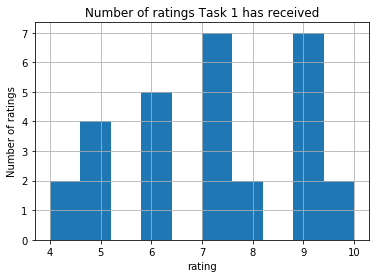

In [212]:
import matplotlib.pyplot as plt
%matplotlib inline
combined_task_data.loc[combined_task_data['TaskId'] == 1]['rating'].hist()
#fig = plt.figure()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings Task 1 has received')
plt.show();
